In [188]:
%reset -f

In [189]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
import pandas as pd

from commpy.modulation import QAMModem, PSKModem

from optic.core import parameters
from optic.tx import simpleWDMTx
from optic.plot import pconst

from optic.models import linFiberCh, manakovSSF, ssfm, linFiberCh, awgn
from optic.models import phaseNoise, coherentReceiver, pdmCoherentReceiver, hybrid_2x4_90deg

from optic.dsp import pulseShape, firFilter, decimate, symbolSync
from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power

import logging as logg
logg.getLogger().setLevel(logg.INFO)
logg.basicConfig(format='%(message)s')

In [190]:
def singleEnded_PD(Ein, Rd=1):
    """
    Single-Ended photodetector

    :param Ein: IQ signal
    :param R: photodiode responsivity [A/W][scalar, default: 1 A/W]
    
    :return: detected analog signals
    """
    assert Rd > 0, "PD responsivity should be a positive scalar"

    Eout = Rd*Ein*np.conj(Ein)
    
    return Eout

In [191]:
def SEReceiver(Es, Elo, Rd=1):
    """
    Single polarization single-ended coherent receiver (SER)

    :param Es: received signal field [nparray]
    :param Elo: LO field [nparray]
    :param Rd: photodiode responsivity [A/W][scalar, default: 1 A/W]

    :return: downconverted signal after single-ended photodetector
    """
    assert Rd > 0, "PD responsivity should be a positive scalar"
    assert Es.size == Elo.size, "Es and Elo need to have the same size"

    # optical 2 x 4 90° hybrid
    Eo = hybrid_2x4_90deg(Es, Elo)
    
    E1 = 2*Eo[1,:]  # select SER port and compensation
    E2 = 2*Eo[2,:]  # select SER port and compensation
    
    R1 = singleEnded_PD(E1, Rd)
    R2 = singleEnded_PD(E2, Rd)
    
    return R1, R2

Estudo de caso:

- Análise de desempenho de um sistema de transmissão de 100 Gbaud com receptor single-ended em configuração back-to-back e 160 km de transmissão para formatos de modulação QAM. A análise é dada pela verificação do valor da SNR usando os símbolos QAM recebidos a medida que a LOSPR é variada.

In [192]:
# Variáveis auxiliares para análise
auxM      = 64    # Ordem do formato de modulação
auxLtotal = 160   # Distância do enlace
auxLOSPR  = 20    # LOSPR do sistema

In [193]:
# Parâmetros - Transmissor
paramTx = parameters()

paramTx.M   = auxM          # Ordem do formato de modulação
paramTx.constType = 'qam'   # Formato de modulação ('qam' ou 'psk')

paramTx.Rs  = 100e9         # Taxa de sinalização [baud]
paramTx.SpS = 4             # Número de amostras por símbolo
Fs = paramTx.Rs*paramTx.SpS # Taxa de amostragem [Hz]

paramTx.Nbits = 300000      # Número total de bits por polarização

paramTx.pulse    = 'rrc'    # Tipo do filtro formatador de pulso
paramTx.Ntaps    = 1024     # Número de coeficientes do filtro
paramTx.alphaRRC = 0.01     # Rolloff do pulso RRC

paramTx.Pch_dBm  = 0        # Potência média por canal WDM [dBm]
paramTx.Nch      = 1        # Número de canais WDM

paramTx.Fc     = 193.1e12   # Frequência central de operação
paramTx.Nmodes = 1          # Número de modos de polarização

# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm


In [194]:
# Parâmetros - Canal Óptico
paramCh = parameters()

paramCh.Ltotal = auxLtotal # Distância total do enlace [km]
paramCh.alpha = 0#0.2      # Parâmetro de perda da fibra [dB/km
paramCh.D = 16             # Parâmetro de dispersão da fibra [ps/nm/km]
paramCh.Fc = paramTx.Fc    # Frequência central de operação [Hz]
paramCh.Fs = Fs            # Taxa de amostragem [Hz]

sigWDM = linFiberCh(sigWDM_Tx, paramCh.Ltotal, paramCh.alpha, paramCh.D, paramCh.Fc, paramCh.Fs)
sigWDM = sigWDM.reshape(len(sigWDM),1)

Text(0.5, 1.0, 'optical WDM spectrum')

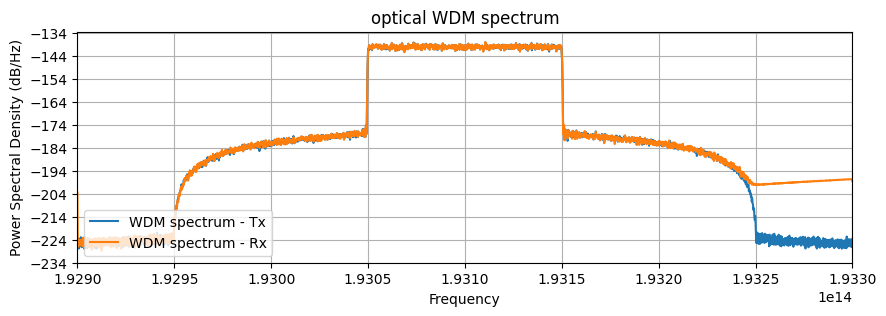

In [195]:
# plot psd
plt.figure(figsize=(10, 3))
plt.xlim(paramCh.Fc-Fs/2,paramCh.Fc+Fs/2)
plt.psd(sigWDM_Tx[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.psd(sigWDM[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
plt.legend(loc='lower left')
plt.title('optical WDM spectrum')

In [196]:
#############################################
# Parâmetros - Receptor
mod = QAMModem(m=paramTx.M)

chIndex  = 0     # Posição do canal WDM a ser demodulado
Fc = paramTx.Fc
Ts = 1/Fs

freqGrid = paramTx.freqGrid
print(f'Demodulating channel #{chIndex} \n',
      f'- fc: {((Fc + freqGrid[chIndex])/1e12):.4f} THz\n',
      f'- λ: {(const.c/(Fc + freqGrid[chIndex])/1e-9):.4f} nm\n')

symbTx = symbTx_[:,:,chIndex]

#############################################
# Parâmetros - Receptor - Oscilador Local
potRx   = 10*np.log10(signal_power(sigWDM)*1e3) # Potência do sinal recebido [dBm]
LOSPR   = auxLOSPR                              # Relação potência do sinal-LO [dB]

π       = np.pi
FO      = 0*64e6                # Offset de frequência
Δf_lo   = freqGrid[chIndex]+FO  # Deslocamento de frequência do canal a ser demodulado
lw      = 0*100e3               # LineWidth
Plo_dBm = potRx+LOSPR           # Potência [dBm]
Plo     = 10**(Plo_dBm/10)*1e-3 # Potência [W]
ϕ_lo    = 0                     # Fase inicial [rad]   

print(f'Local oscillator\n',
      f'- Power: {Plo_dBm:.2f} dBm\n',
      f'- LOSPR: {LOSPR:.2f} dBm\n',
      f'- LineWidth: {(lw/1e3):.2f} kHz\n',
      f'- Frequency offset: {(FO/1e6):.2f} MHz')

#############################################
# Geração do sinal LO
t       = np.arange(0, len(sigWDM))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ts)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

Demodulating channel #0 
 - fc: 193.1000 THz
 - λ: 1552.5244 nm

Local oscillator
 - Power: 20.00 dBm
 - LOSPR: 20.00 dBm
 - LineWidth: 0.00 kHz
 - Frequency offset: 0.00 MHz


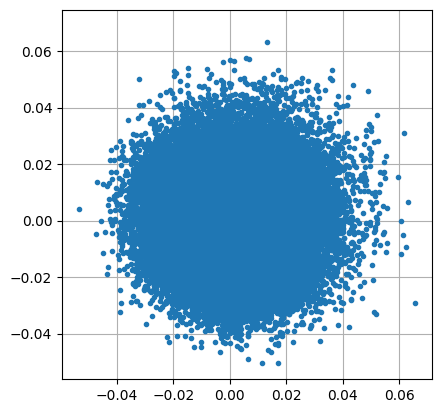

In [197]:
# Receptor óptico single-ended
sigWDM = sigWDM.reshape(len(sigWDM),)
R1, R2 = SEReceiver(sigWDM, sigLO, Rd=1)
 
sigPD = R1 + 1j*R2
sigPD = sigPD - np.mean(sigPD)
    
sigRx = sigPD

# plot constellations (pós-receptor coerente)
pconst(sigRx[0::paramTx.SpS], lim=False, R=3)

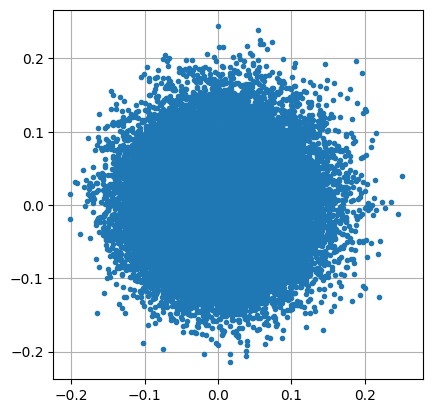

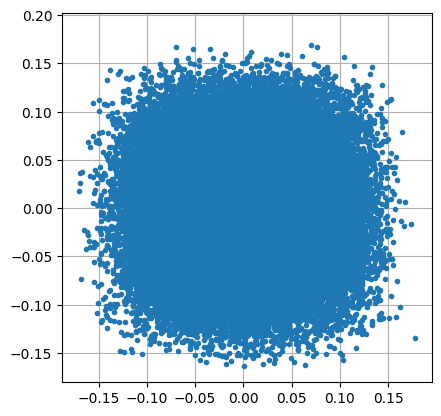

In [198]:
# Filtro casado
pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)
pulse = pulse/np.max(np.abs(pulse))

sigRx = firFilter(pulse, sigRx)
    
# plot constellations (pós-filtragem)
pconst(sigRx[0::paramTx.SpS], lim=False, R=3)

# Compensação da disperção cromática
if (paramCh.Ltotal > 0):    
    sigRx = edc(sigRx, paramCh.Ltotal, paramCh.D, Fc-Δf_lo, Fs)
    
    # plot constellations (pós-filtragem+compensação)
    pconst(sigRx[0::paramTx.SpS], lim=False, R=3)

In [199]:
# Redução de amostras por símbolos
paramDec = parameters()

paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 2

sigRx = sigRx.reshape(len(sigRx), 1)
sigRx = decimate(sigRx, paramDec)
symbRx = symbolSync(sigRx, symbTx, 2)

In [200]:
x = sigRx
d = symbRx

x = x.reshape(len(x),1)/np.sqrt(signal_power(x))
d = d.reshape(len(d),1)/np.sqrt(signal_power(d))

nlms - training stage #0
nlms pre-convergence training iteration #0
nlms MSE = 0.003847.
nlms pre-convergence training iteration #1
nlms MSE = 0.003847.
nlms pre-convergence training iteration #2
nlms MSE = 0.003846.
nlms pre-convergence training iteration #3
nlms MSE = 0.003846.
nlms pre-convergence training iteration #4
nlms MSE = 0.003846.
da-rde - training stage #1
da-rde MSE = 0.008607.


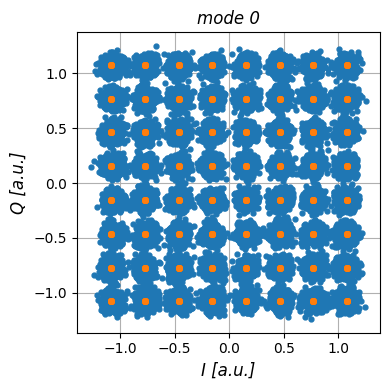

In [201]:
# Algoritmo de Equalização
paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS   = 2
paramEq.mu    = [3e-3, 4e-3]
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg   = ['nlms','da-rde']
paramEq.M     = paramTx.M
paramEq.L = [int(0.20*len(x)/2), int(0.80*len(x)/2)]
paramEq.prgsBar = False

y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

# plot constellations (pós-equalização)
discard = 5000
plt.figure(figsize=(4,4))
plt.plot(np.squeeze(y_EQ[discard:-discard,:]).real, np.squeeze(y_EQ[discard:-discard,:]).imag,'.', markersize=7)
plt.plot(np.squeeze(d).real, np.squeeze(d).imag,'.', markersize=7)
plt.title('mode 0', fontsize=12.0, fontstyle='oblique')
plt.xlabel('I [a.u.]', fontsize=12.0, fontstyle='oblique')
plt.ylabel('Q [a.u.]', fontsize=12.0, fontstyle='oblique')
plt.grid()
plt.tight_layout()
plt.show()

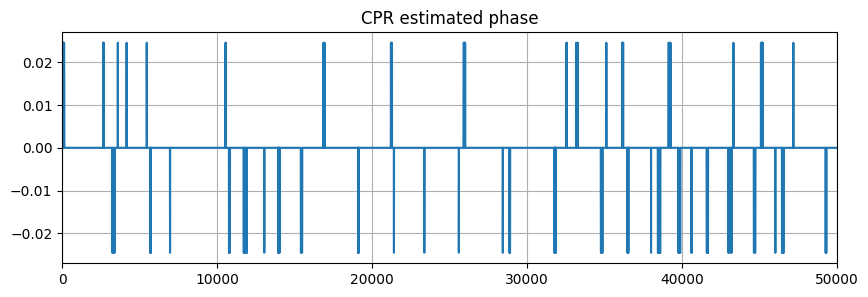

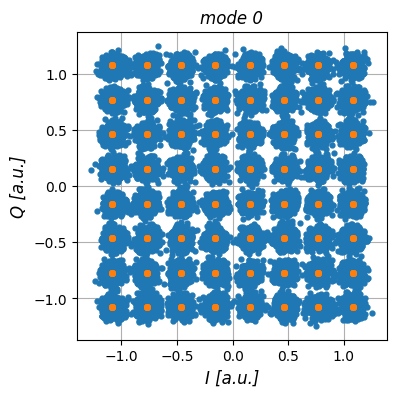

In [202]:
# Algoritmo de Recuperação de Fase
paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = paramTx.M
paramCPR.N   = 120
paramCPR.B   = 64
paramCPR.pilotInd = np.arange(0, len(y_EQ), 20) 

y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))

plt.figure(figsize=(10, 3))
plt.title('CPR estimated phase')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid()

# plot constellations (pós-CPR)
discard = 5000
plt.figure(figsize=(4,4))
plt.plot(np.squeeze(y_CPR[discard:-discard,:]).real, np.squeeze(y_CPR[discard:-discard,:]).imag,'.', markersize=7)
plt.plot(np.squeeze(d).real, np.squeeze(d).imag,'.', markersize=7)
plt.title('mode 0', fontsize=12.0, fontstyle='oblique')
plt.xlabel('I [a.u.]', fontsize=12.0, fontstyle='oblique')
plt.ylabel('Q [a.u.]', fontsize=12.0, fontstyle='oblique')
plt.grid()
plt.show()

In [203]:
# correct (possible) phase ambiguity
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:,k]/y_CPR[:,k])
    y_CPR[:,k] = rot*y_CPR[:,k]

y_CPR = y_CPR/np.sqrt(signal_power(y_CPR))


ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
GMI,_    = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')

polx = [BER[0],SER[0],SNR[0],MI[0],GMI[0]]
results = np.array([polx])

df2 = pd.DataFrame(results, index=['Pol. X'], columns=['BER', 'SER', 'SNR [dB]', 'GMI [bits]', 'MI [bits]'])
df2.style.format({"BER": "{:.2e}", "SER": "{:.2e}", "SNR [dB]": "{:.2f}", "GMI [bits]": "{:.2f}", "MI [bits]": "{:.2f}"})

,BER,SER,SNR [dB],GMI [bits],MI [bits]
Pol. X,2.42e-04,1.45e-03,23.84,5.99,5.99


In [204]:
# # Salvar variáveis em arquivos externos
# import pickle

# nameFile = f'fig3A_{paramTx.M}QAM_L-{paramCh.Ltotal}km_LOSPR-{LOSPR}dB.pkl'

# status = {
#       'MQAM': paramTx.M,
#       'Distância': paramCh.Ltotal,
#       'LOSPR': LOSPR,
#       'SNR': SNR[0],
#       'BER': BER[0]
#     }

# with open(nameFile, 'wb') as arquivo:
#     pickle.dump(status, arquivo)
#     print(f'Arquivo {nameFile} criado!')
#     print(status)

Arquivo fig3A_64QAM_L-160km_LOSPR-20dB.pkl criado!
{'MQAM': 64, 'Distância': 160, 'LOSPR': 20, 'SNR': 23.83994965222758, 'BER': 0.00024166666666666667}
